In [83]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import sys, os, shutil
import json
from pathlib import Path
from tqdm import tqdm
from collections import defaultdict, Counter
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Image as IImage

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)

sys.path.insert(0,'/home/ubuntu/git/fastai/')

def show_dct(dct, n=3):
    return dict(list(dct.items())[:n])

# http://www.racketracer.com/2016/07/06/pandas-in-parallel/
from multiprocessing import cpu_count, Pool
num_jobs = cpu_count() #number of cores on your machine
num_partitions = num_jobs*2 #number of partitions to split dataframe
def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_jobs)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Clone the repositories

# Download the dataset

In [1]:
!chmod +x download.sh

In [51]:
p = Path('/home/yang/git/pytorch-tutorial/tutorials/03-advanced/image_captioning/data')

# Preprocessing

## build_vocab

In [1]:
import nltk
import pickle
import argparse
from collections import Counter
from pycocotools.coco import COCO


class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

def build_vocab(json, threshold):
    """Build a simple vocabulary wrapper."""
    coco = COCO(json)
    counter = Counter()
    ids = coco.anns.keys()
    for i, id in enumerate(ids):
        caption = str(coco.anns[id]['caption'])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)

        if (i+1) % 1000 == 0:
            print("[{}/{}] Tokenized the captions.".format(i+1, len(ids)))

    # If the word frequency is less than 'threshold', then the word is discarded.
    words = [word for word, cnt in counter.items() if cnt >= threshold]

    # Create a vocab wrapper and add some special tokens.
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')

    # Add the words to the vocabulary.
    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab

def main(args):
    vocab = build_vocab(json=args.caption_path, threshold=args.threshold)
    vocab_path = args.vocab_path
    with open(vocab_path, 'wb') as f:
        pickle.dump(vocab, f)
    print("Total vocabulary size: {}".format(len(vocab)))
    print("Saved the vocabulary wrapper to '{}'".format(vocab_path))


# if __name__ == '__main__':
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--caption_path', type=str, 
#                         default='data/annotations/captions_train2014.json', 
#                         help='path for train annotation file')
#     parser.add_argument('--vocab_path', type=str, default='./data/vocab.pkl', 
#                         help='path for saving vocabulary wrapper')
#     parser.add_argument('--threshold', type=int, default=4, 
#                         help='minimum word count threshold')
#     args = parser.parse_args()
#     main(args)

## resize

In [5]:
import argparse
import os
from PIL import Image


def resize_image(image, size):
    """Resize an image to the given size."""
    return image.resize(size, Image.ANTIALIAS)

def resize_images(image_dir, output_dir, size):
    """Resize the images in 'image_dir' and save into 'output_dir'."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    images = os.listdir(image_dir)
    num_images = len(images)
    for i, image in enumerate(images):
        with open(os.path.join(image_dir, image), 'r+b') as f:
            with Image.open(f) as img:
                img = resize_image(img, size)
                img.save(os.path.join(output_dir, image), img.format)
        if (i+1) % 100 == 0:
            print ("[{}/{}] Resized the images and saved into '{}'."
                   .format(i+1, num_images, output_dir))

def main(args):
    image_dir = args.image_dir
    output_dir = args.output_dir
    image_size = [args.image_size, args.image_size]
    resize_images(image_dir, output_dir, image_size)


# if __name__ == '__main__':
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--image_dir', type=str, default='./data/train2014/',
#                         help='directory for train images')
#     parser.add_argument('--output_dir', type=str, default='./data/resized2014/',
#                         help='directory for saving resized images')
#     parser.add_argument('--image_size', type=int, default=256,
#                         help='size for image after processing')
#     args = parser.parse_args()
#     main(args)

# Explore data


In [52]:
ls $p

annotations/  resized2014/  train2014/  val2014/  vocab.pkl


## anno

In [69]:
ls $p/annotations

captions_train2014.json  captions_val2014.json


In [70]:
j_trn = json.load(open(p/"annotations/captions_train2014.json"))
j_val = json.load(open(p/"annotations/captions_val2014.json"))

In [71]:
j_trn.keys(), j_val.keys()

(dict_keys(['info', 'images', 'licenses', 'annotations']),
 dict_keys(['info', 'images', 'licenses', 'annotations']))

In [110]:
len(j_trn['images']), j_trn['images'][:2]

(82783,
 [{'license': 5,
   'file_name': 'COCO_train2014_000000057870.jpg',
   'coco_url': 'http://mscoco.org/images/57870',
   'height': 480,
   'width': 640,
   'date_captured': '2013-11-14 16:28:13',
   'flickr_url': 'http://farm4.staticflickr.com/3153/2970773875_164f0c0b83_z.jpg',
   'id': 57870},
  {'license': 5,
   'file_name': 'COCO_train2014_000000384029.jpg',
   'coco_url': 'http://mscoco.org/images/384029',
   'height': 429,
   'width': 640,
   'date_captured': '2013-11-14 16:29:45',
   'flickr_url': 'http://farm3.staticflickr.com/2422/3577229611_3a3235458a_z.jpg',
   'id': 384029}])

In [73]:
len(j_trn['annotations']), j_trn['annotations'][0]

(414113,
 {'image_id': 318556,
  'id': 48,
  'caption': 'A very clean and well decorated empty bathroom'})

## images

In [76]:
len(list((p/'resized2014').iterdir())), len(list((p/'train2014').iterdir()))

(82783, 82783)

In [77]:
len(list((p/'val2014').iterdir()))

40504

In [92]:
str(list((p/'train2014').iterdir())[0])

'/home/yang/git/pytorch-tutorial/tutorials/03-advanced/image_captioning/data/train2014/COCO_train2014_000000507946.jpg'

In [91]:
str(list((p/'resized2014').iterdir())[0])

'/home/yang/git/pytorch-tutorial/tutorials/03-advanced/image_captioning/data/resized2014/COCO_train2014_000000507946.jpg'

## vocab

In [93]:
with open('data/vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

In [104]:
vocab.idx, len(vocab.idx2word)

(9957, 9957)

In [107]:
show_dct(vocab.idx2word, 20)

{0: '<pad>',
 1: '<start>',
 2: '<end>',
 3: '<unk>',
 4: 'a',
 5: 'very',
 6: 'clean',
 7: 'and',
 8: 'well',
 9: 'decorated',
 10: 'empty',
 11: 'bathroom',
 12: 'panoramic',
 13: 'view',
 14: 'of',
 15: 'kitchen',
 16: 'all',
 17: 'its',
 18: 'appliances',
 19: '.'}

In [109]:
show_dct(vocab.word2idx, 10)

{'<pad>': 0,
 '<start>': 1,
 '<end>': 2,
 '<unk>': 3,
 'a': 4,
 'very': 5,
 'clean': 6,
 'and': 7,
 'well': 8,
 'decorated': 9}

# Train the model

In [8]:
import argparse
import torch
import torch.nn as nn
import numpy as np
import os
import pickle
from data_loader import get_loader 
from build_vocab import Vocabulary
from model import EncoderCNN, DecoderRNN
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def main(args):
    # Create model directory
    if not os.path.exists(args.model_path):
        os.makedirs(args.model_path)
    
    # Image preprocessing, normalization for the pretrained resnet
    transform = transforms.Compose([ 
        transforms.RandomCrop(args.crop_size),
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
    # Load vocabulary wrapper
    with open(args.vocab_path, 'rb') as f:
        vocab = pickle.load(f)
    
    # Build data loader
    data_loader = get_loader(args.image_dir, args.caption_path, vocab, 
                             transform, args.batch_size,
                             shuffle=True, num_workers=args.num_workers) 

    # Build the models
    encoder = EncoderCNN(args.embed_size).to(device)
    decoder = DecoderRNN(args.embed_size, args.hidden_size, len(vocab), args.num_layers).to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
    optimizer = torch.optim.Adam(params, lr=args.learning_rate)
    
    # Train the models
    total_step = len(data_loader)
    for epoch in range(args.num_epochs):
        for i, (images, captions, lengths) in enumerate(data_loader):
            
            # Set mini-batch dataset
            images = images.to(device)
            captions = captions.to(device)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
            
            # Forward, backward and optimize
            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            loss = criterion(outputs, targets)
            decoder.zero_grad()
            encoder.zero_grad()
            loss.backward()
            optimizer.step()

            # Print log info
            if i % args.log_step == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                      .format(epoch, args.num_epochs, i, total_step, loss.item(), np.exp(loss.item()))) 
                
            # Save the model checkpoints
            if (i+1) % args.save_step == 0:
                torch.save(decoder.state_dict(), os.path.join(
                    args.model_path, 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
                torch.save(encoder.state_dict(), os.path.join(
                    args.model_path, 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))


# if __name__ == '__main__':
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--model_path', type=str, default='models/' , help='path for saving trained models')
#     parser.add_argument('--crop_size', type=int, default=224 , help='size for randomly cropping images')
#     parser.add_argument('--vocab_path', type=str, default='data/vocab.pkl', help='path for vocabulary wrapper')
#     parser.add_argument('--image_dir', type=str, default='data/resized2014', help='directory for resized images')
#     parser.add_argument('--caption_path', type=str, default='data/annotations/captions_train2014.json', help='path for train annotation json file')
#     parser.add_argument('--log_step', type=int , default=10, help='step size for prining log info')
#     parser.add_argument('--save_step', type=int , default=1000, help='step size for saving trained models')
    
#     # Model parameters
#     parser.add_argument('--embed_size', type=int , default=256, help='dimension of word embedding vectors')
#     parser.add_argument('--hidden_size', type=int , default=512, help='dimension of lstm hidden states')
#     parser.add_argument('--num_layers', type=int , default=1, help='number of layers in lstm')
    
#     parser.add_argument('--num_epochs', type=int, default=5)
#     parser.add_argument('--batch_size', type=int, default=128)
#     parser.add_argument('--num_workers', type=int, default=2)
#     parser.add_argument('--learning_rate', type=float, default=0.001)
#     args = parser.parse_args()
#     print(args)
#     main(args)

# Test the model

In [12]:
import torch
import matplotlib.pyplot as plt
import numpy as np 
import argparse
import pickle 
import os
from torchvision import transforms 
from build_vocab import Vocabulary
from model import EncoderCNN, DecoderRNN
from PIL import Image


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

def main(args):
    # Image preprocessing
    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
    # Load vocabulary wrapper
    with open(args.vocab_path, 'rb') as f:
        vocab = pickle.load(f)

    # Build models
    encoder = EncoderCNN(args.embed_size).eval()  # eval mode (batchnorm uses moving mean/variance)
    decoder = DecoderRNN(args.embed_size, args.hidden_size, len(vocab), args.num_layers)
    encoder = encoder.to(device)
    decoder = decoder.to(device)

    # Load the trained model parameters
    encoder.load_state_dict(torch.load(args.encoder_path))
    decoder.load_state_dict(torch.load(args.decoder_path))

    # Prepare an image
    image = load_image(args.image, transform)
    image_tensor = image.to(device)
    
    # Generate an caption from the image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)
    
    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)
    
    # Print out the image and the generated caption
    print (sentence)
    image = Image.open(args.image)
    plt.imshow(np.asarray(image))
    
# if __name__ == '__main__':
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--image', type=str, required=True, help='input image for generating caption')
#     parser.add_argument('--encoder_path', type=str, default='models/encoder-2-1000.ckpt', help='path for trained encoder')
#     parser.add_argument('--decoder_path', type=str, default='models/decoder-2-1000.ckpt', help='path for trained decoder')
#     parser.add_argument('--vocab_path', type=str, default='data/vocab.pkl', help='path for vocabulary wrapper')
    
#     # Model parameters (should be same as paramters in train.py)
#     parser.add_argument('--embed_size', type=int , default=256, help='dimension of word embedding vectors')
#     parser.add_argument('--hidden_size', type=int , default=512, help='dimension of lstm hidden states')
#     parser.add_argument('--num_layers', type=int , default=1, help='number of layers in lstm')
#     args = parser.parse_args()
#     main(args)

<start> a group of giraffes standing in a field . <end>


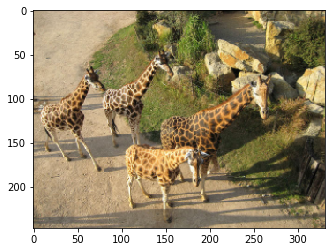

In [43]:
parser = argparse.ArgumentParser()
parser.add_argument('--image', type=str, required=True, help='input image for generating caption')
parser.add_argument('--encoder_path', type=str, default='models/encoder-2-1000.ckpt', help='path for trained encoder')
parser.add_argument('--decoder_path', type=str, default='models/decoder-2-1000.ckpt', help='path for trained decoder')
parser.add_argument('--vocab_path', type=str, default='data/vocab.pkl', help='path for vocabulary wrapper')

# Model parameters (should be same as paramters in train.py)
parser.add_argument('--embed_size', type=int , default=256, help='dimension of word embedding vectors')
parser.add_argument('--hidden_size', type=int , default=512, help='dimension of lstm hidden states')
parser.add_argument('--num_layers', type=int , default=1, help='number of layers in lstm')
args = parser.parse_args(["--image", "png/example.png"])
main(args)

In [44]:
from pathlib import Path
p = Path("/home/yang/data/pascal/VOCdevkit/VOC2007/JPEGImages")

<start> a red and yellow train on a train track <end>


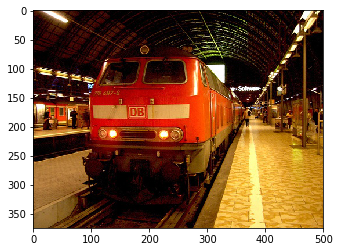

In [49]:
args = parser.parse_args(f"--image {np.random.choice(list(p.iterdir()))}".split())

main(args)